# Sajal Gangrade
# ALY 6020 - Predictive Analytics
# Paris Housing Price Prediction

# 

# Data Cleaning & EDA #

In [64]:
# ===============================================
# 1. Data Loading and Initial Inspection
# ===============================================

# Step 1: Import required libraries
import pandas as pd

# Step 2: Load the dataset
df = pd.read_csv('paris_housing_regression.csv')

# Step 3: Preview the dataset
print("🔹 First 5 rows of the dataset:")
print(df.head())

# Step 4: Display basic structure and column types
print("\n🔹 Dataset Info:")
print(df.info())  # Includes non-null counts and data types

# Step 5: Check for missing values
print("\n🔹 Missing Values:")
print(df.isnull().sum())  # Identifies how many nulls are present in each column

# Step 6: View summary statistics for numeric columns
print("\n🔹 Summary Statistics:")
print(df.describe())  # Provides mean, std, min, max, and percentiles


🔹 First 5 rows of the dataset:
   hasYard  hasPool  floors  cityCode  cityPartRange  numPrevOwners  \
0        0        1     2.0     53236            7.0              1   
1        0        0    79.0     78649            7.0              6   
2        1        1     NaN     39708           10.0             10   
3        1        0     NaN     17489            1.0              7   
4        0        0    95.0     35955            6.0              6   

   isNewBuilt  hasStormProtector  garage  hasStorageRoom  hasGuestRoom  \
0           0                  0     736               1           2.0   
1           1                  1     742               0           3.0   
2           1                  1     329               1           NaN   
3           0                  1     859               1           8.0   
4           1                  1     338               0           5.0   

   basementarea  atticarea  squaremeters      price     rooms  
0      8.731175   9.207336     11

In [66]:
# ---------------------------------------------------------------
# Categorical Variables Handling
# ---------------------------------------------------------------
# The following binary categorical variables are already encoded as 0/1 integers:
# 'hasYard', 'hasPool', 'isNewBuilt', 'hasStormProtector', 'hasStorageRoom'
# Therefore, no additional encoding (such as one-hot encoding) is necessary.


In [68]:
# Drop 'floors' column due to excessive missing values (more than 50%)
# Reason: With over 4000 missing values out of 8000, imputing may introduce bias or noise.
df.drop('floors', axis=1, inplace=True)

# Impute missing values in 'cityPartRange' using the median
# Reason: This is a numerical feature with ordinal interpretation (exclusivity level of neighborhoods).
# Median is robust to outliers and maintains the ordinal scale.
median_city_part = df['cityPartRange'].median()
df['cityPartRange'].fillna(median_city_part, inplace=True)

# Impute missing values in 'hasGuestRoom' using the median
# Reason: 'hasGuestRoom' is a discrete numerical feature (count-based), and median preserves central tendency.
median_guest = df['hasGuestRoom'].median()
df['hasGuestRoom'].fillna(median_guest, inplace=True)

# Final check to confirm all missing values are handled
print("Final Missing Values Check:")
print(df.isnull().sum())


Final Missing Values Check:
hasYard              0
hasPool              0
cityCode             0
cityPartRange        0
numPrevOwners        0
isNewBuilt           0
hasStormProtector    0
garage               0
hasStorageRoom       0
hasGuestRoom         0
basementarea         0
atticarea            0
squaremeters         0
price                0
rooms                0
dtype: int64


### Hypothesis Test 1: Do properties with a pool tend to have higher prices?

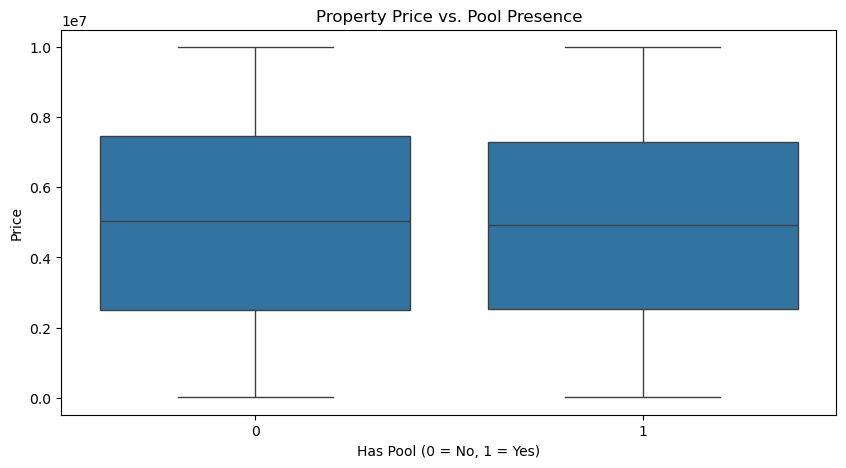

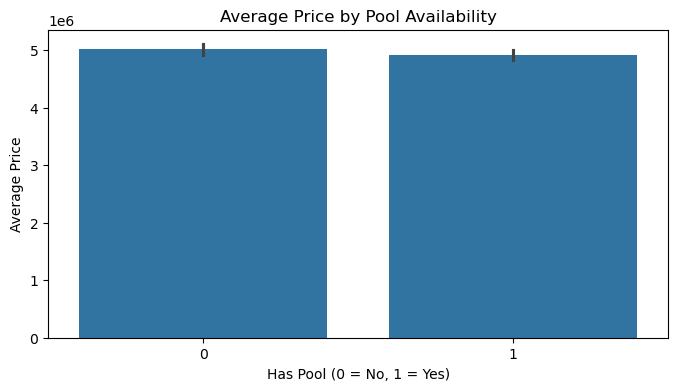

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot to compare price distribution between properties with and without a pool
# Purpose: Visualize spread and presence of outliers; useful to see if pool presence affects price distribution
plt.figure(figsize=(10, 5))
sns.boxplot(x='hasPool', y='price', data=df)
plt.title('Property Price vs. Pool Presence')
plt.xlabel('Has Pool (0 = No, 1 = Yes)')
plt.ylabel('Price')
plt.show()

# Bar plot to compare average property prices by pool availability
# Purpose: Confirm central tendency (mean price) for homes with and without pools
plt.figure(figsize=(8, 4))
sns.barplot(x='hasPool', y='price', data=df, estimator=lambda x: round(x.mean(), 0))
plt.title('Average Price by Pool Availability')
plt.xlabel('Has Pool (0 = No, 1 = Yes)')
plt.ylabel('Average Price')
plt.show()


### Hypothesis Test 2: Do more exclusive neighborhoods (higher cityPartRange) have higher property prices? ###

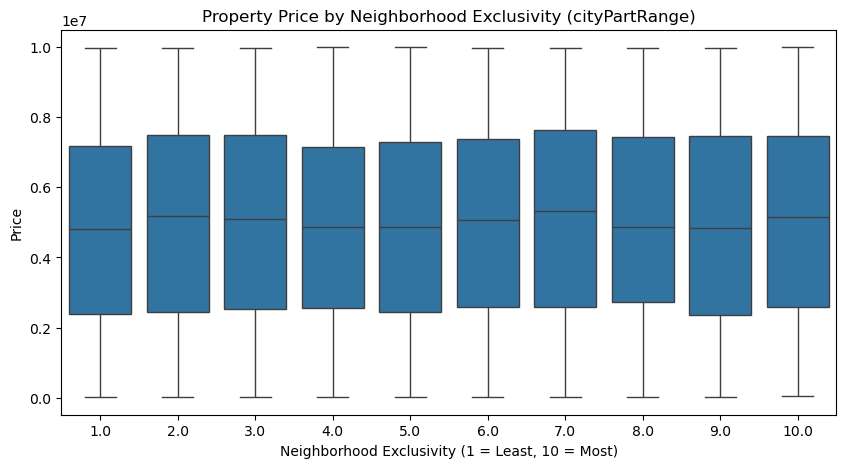

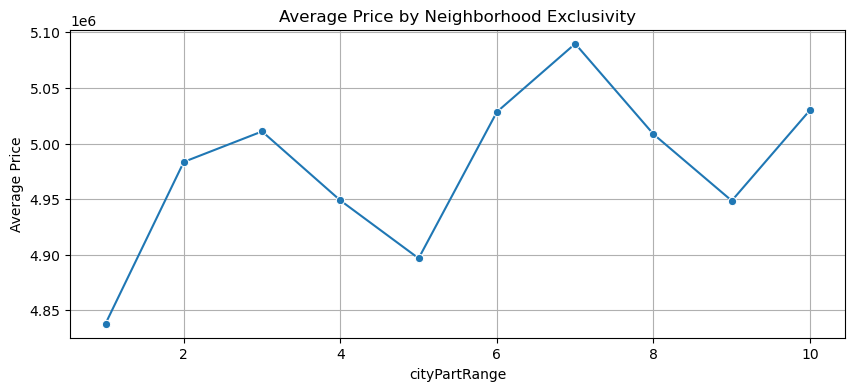

In [72]:
# Boxplot to compare price distribution across different levels of neighborhood exclusivity
# Purpose: Visual inspection to assess how price varies across cityPartRange from 1 (least exclusive) to 10 (most exclusive)
plt.figure(figsize=(10, 5))
sns.boxplot(x='cityPartRange', y='price', data=df)
plt.title('Property Price by Neighborhood Exclusivity (cityPartRange)')
plt.xlabel('Neighborhood Exclusivity (1 = Least, 10 = Most)')
plt.ylabel('Price')
plt.show()

# Line plot of average property price by neighborhood exclusivity
# Purpose: Observe trend in mean price as exclusivity increases
avg_price_by_range = df.groupby('cityPartRange')['price'].mean().reset_index()

plt.figure(figsize=(10, 4))
sns.lineplot(data=avg_price_by_range, x='cityPartRange', y='price', marker='o')
plt.title('Average Price by Neighborhood Exclusivity')
plt.xlabel('cityPartRange')
plt.ylabel('Average Price')
plt.grid(True)
plt.show()


# Model Development and Evaluation #

In [74]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Calculate VIF to detect multicollinearity
# Step 1: Drop target variable
X_vif = df.drop(columns=['price'])

# Step 2: Add constant term
X_vif_const = add_constant(X_vif)

# Step 3: Create DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif_const.values, i) for i in range(X_vif_const.shape[1])]

# Display VIF values
print("🔍 Variance Inflation Factor (VIF) to check multicollinearity:")
print(vif_data.sort_values(by="VIF", ascending=False))


🔍 Variance Inflation Factor (VIF) to check multicollinearity:
              Feature         VIF
0               const  288.466451
9      hasStorageRoom    1.002886
5       numPrevOwners    1.002651
8              garage    1.002506
10       hasGuestRoom    1.002223
4       cityPartRange    1.001996
13       squaremeters    1.001977
14              rooms    1.001940
6          isNewBuilt    1.001550
2             hasPool    1.001476
11       basementarea    1.001234
1             hasYard    1.001116
12          atticarea    1.000959
3            cityCode    1.000643
7   hasStormProtector    1.000364


In [76]:
import statsmodels.api as sm

# Define feature variables (X) and target variable (y)
X = df.drop('price', axis=1)
y = df['price']

# Add a constant term to the predictors to include an intercept in the model
X_const = sm.add_constant(X)

# Fit the Ordinary Least Squares (OLS) regression model
model = sm.OLS(y, X_const).fit()

# Display the model summary, which includes:
# - Coefficients for each predictor
# - p-values to assess statistical significance
# - R-squared and AIC for model evaluation
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     1766.
Date:                Sat, 31 May 2025   Prob (F-statistic):               0.00
Time:                        18:40:10   Log-Likelihood:            -1.2463e+05
No. Observations:                8000   AIC:                         2.493e+05
Df Residuals:                    7985   BIC:                         2.494e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -2.136e+07   2.68e+0

In [56]:
# Interpretation of p-values and coefficients will be discussed in the final report
# to highlight which variables significantly affect property price.


### Forward Stepwise Feature Selection using Linear Regression

In [46]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm

# Step 1: Define predictors and target variable
X = df.drop('price', axis=1)
y = df['price']

# Step 2: Create a pipeline that standardizes the features before fitting the regression
# (Scaling is not mandatory for linear regression but improves numeric stability and condition number)
model = make_pipeline(StandardScaler(), LinearRegression())

# Step 3: Perform forward stepwise selection to choose the best subset of features
sfs = SFS(estimator=model,
          k_features='best',                # Automatically find optimal number of features
          forward=True,                     # Forward selection
          floating=False,                   # No floating (backtracking)
          scoring='neg_mean_squared_error', # MSE as proxy for AIC minimization
          cv=0)                             # Use entire dataset for fitting (no CV)

sfs.fit(X.values, y.values)

# Step 4: Extract the selected features
selected_features = list(X.columns[list(sfs.k_feature_idx_)])
print("Selected Features via Stepwise Selection:")
print(selected_features)

# Step 5: Fit a new OLS model using the selected features
X_selected = sm.add_constant(X[selected_features])
stepwise_model = sm.OLS(y, X_selected).fit()

# Step 6: Display regression results for the stepwise-selected model
print(stepwise_model.summary())


Selected Features via Stepwise Selection:
['hasYard', 'hasPool', 'cityCode', 'cityPartRange', 'numPrevOwners', 'isNewBuilt', 'hasStormProtector', 'garage', 'hasStorageRoom', 'hasGuestRoom', 'basementarea', 'atticarea', 'squaremeters', 'rooms']
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     1766.
Date:                Sat, 31 May 2025   Prob (F-statistic):               0.00
Time:                        17:49:42   Log-Likelihood:            -1.2463e+05
No. Observations:                8000   AIC:                         2.493e+05
Df Residuals:                    7985   BIC:                         2.494e+05
Df Model:                          14                                         
Covariance Type:            nonrobust        

In [58]:
# Based on this model, key recommendations for the property business 
# will be derived and explained in the report.



### OPTIONAL ENHANCEMENT: Log-Transformed Linear Regression Model
### Purpose: To reduce skewness and improve model assumptions


In [48]:
import numpy as np
import statsmodels.api as sm

# Step 1: Log-transform the target variable to address skewness and heteroscedasticity
df['log_price'] = np.log(df['price'])

# Step 2: Use the same features as in the stepwise selection for consistency
X = df[['hasYard', 'hasPool', 'cityCode', 'cityPartRange', 'numPrevOwners',
        'isNewBuilt', 'hasStormProtector', 'garage', 'hasStorageRoom',
        'hasGuestRoom', 'basementarea', 'atticarea', 'squaremeters', 'rooms']]

# Step 3: Define the new target as log(price)
y = df['log_price']

# Step 4: Add constant term for intercept
X_const = sm.add_constant(X)

# Step 5: Fit the OLS model using the log-transformed target
log_model = sm.OLS(y, X_const).fit()

# Step 6: Display the regression summary for evaluation
print(log_model.summary())


                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.535e+06
Date:                Sat, 31 May 2025   Prob (F-statistic):               0.00
Time:                        17:49:44   Log-Likelihood:                 22349.
No. Observations:                8000   AIC:                        -4.467e+04
Df Residuals:                    7985   BIC:                        -4.456e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.7246      0.00

In [60]:
# Optional: Log-transformed model used to improve residual behavior and variance stability.
# Included for comparison; main model interpretation remains based on the original price variable.
